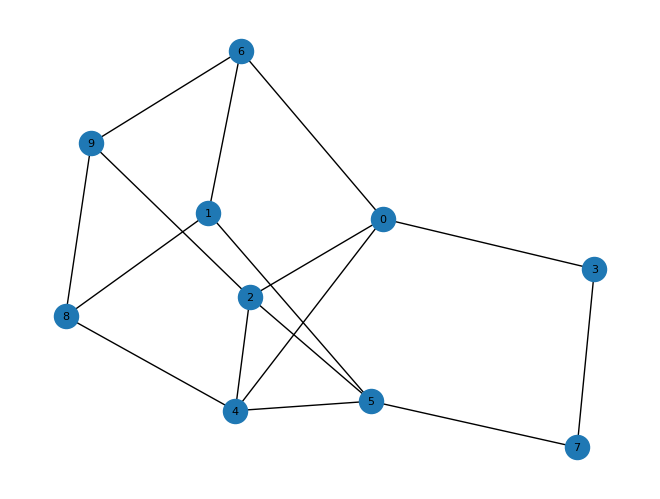

In [258]:
import networkx as nx
import random
import matplotlib.pyplot as plt

n = 10

graph = nx.Graph()

graph.add_nodes_from(range(n))

nodes = list(range(n))
random.shuffle(nodes)

for i in range(n - 1):
    weight = round(random.uniform(0.1, 10.0), 2)
    graph.add_edge(nodes[i], nodes[i + 1], weight=1)

num_extra_edges = random.randint(0, n) 
while len(graph.edges) < n + num_extra_edges:
    u, v = random.sample(range(n), 2)
    if not graph.has_edge(u, v):
        weight = round(random.uniform(0.1, 10.0), 2)
        graph.add_edge(u, v, weight=1)

nx.draw(graph, with_labels=True, node_size=300, font_size=8)
plt.show()
edge_list = [(u, v, data['weight']) for u, v, data in graph.edges(data=True)]

In [259]:
from qiskit.quantum_info import SparsePauliOp
def build_hamiltonian(n, edge_list):
    pauli_list = []
    for (i, j, weight) in edge_list:
        pauli_list.append(["I"] * n)
        pauli_list[-1][i] = "Z"
        pauli_list[-1][j] = "Z"
        pauli_list[-1] = ("".join(pauli_list[-1])[::-1], weight)
    return SparsePauliOp.from_list(pauli_list)

In [260]:
print("Cost Function Hamiltonian:", build_hamiltonian(n, edge_list))

Cost Function Hamiltonian: SparsePauliOp(['IIIIIZIIIZ', 'IIIIIIZIIZ', 'IIIIIIIZIZ', 'IIIZIIIIIZ', 'IIIZIIIIZI', 'IZIIIIIIZI', 'IIIIZIIIZI', 'IIIIZIIZII', 'ZIIIIIIZII', 'IIIIIZIZII', 'IIZIIIZIII', 'IZIIIZIIII', 'IIIIZZIIII', 'IIZIZIIIII', 'ZIIZIIIIII', 'ZZIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


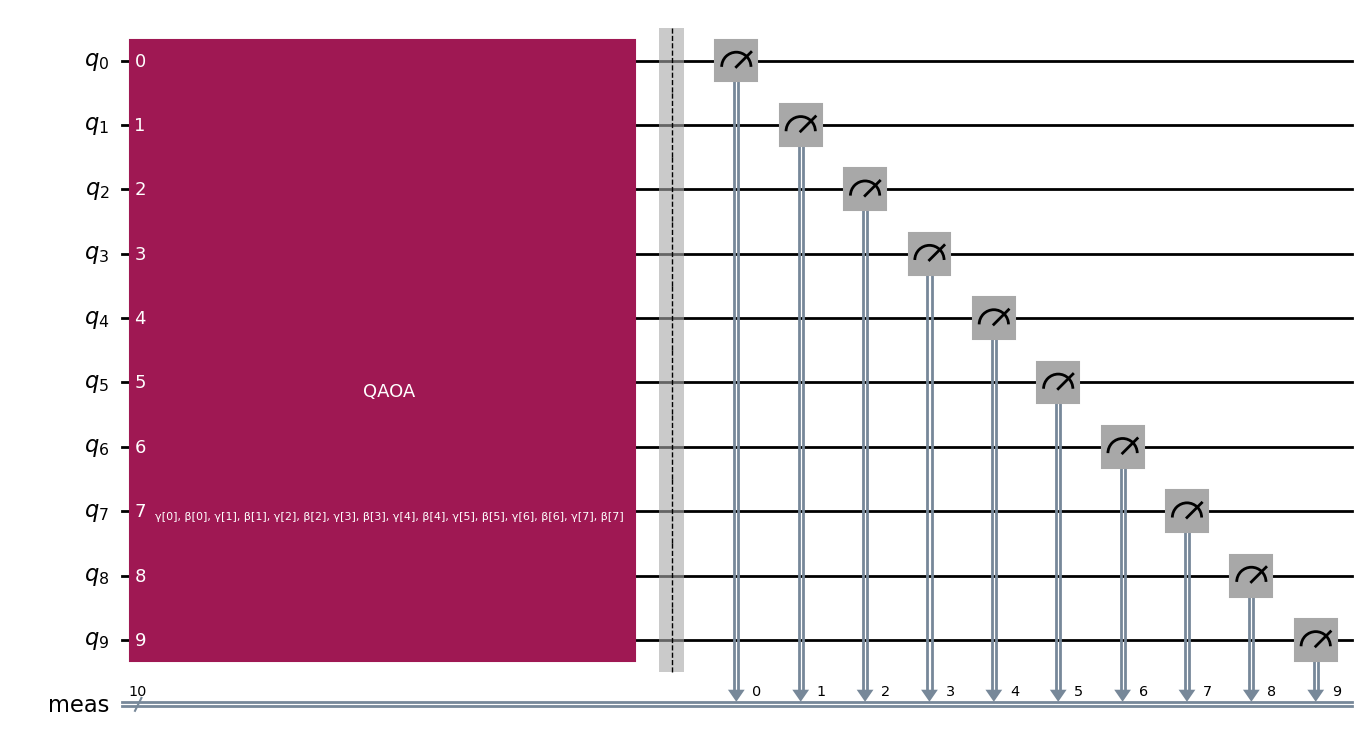

In [261]:
from qiskit.circuit.library import QAOAAnsatz
repeat_time = 8
circuit = QAOAAnsatz(cost_operator=build_hamiltonian(n, edge_list), reps=repeat_time)
circuit.measure_all()

circuit.draw('mpl')

In [262]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(β[3]), ParameterVectorElement(β[4]), ParameterVectorElement(β[5]), ParameterVectorElement(β[6]), ParameterVectorElement(β[7]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2]), ParameterVectorElement(γ[3]), ParameterVectorElement(γ[4]), ParameterVectorElement(γ[5]), ParameterVectorElement(γ[6]), ParameterVectorElement(γ[7])])

AerSimulator('aer_simulator')


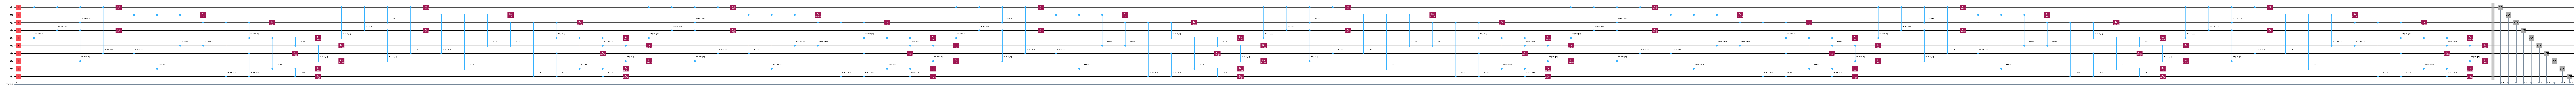

In [263]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator


# 使用 AerSimulator 作为本地后端
backend = AerSimulator()

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
# backend = service.least_busy(min_num_qubits=127)
print(backend)
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)
candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [264]:
import numpy as np
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_beta] * repeat_time + [initial_gamma] * repeat_time

In [265]:
objective_func_vals = []
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)
    print(len(objective_func_vals), "th iteration's cost: ", objective_func_vals[-1])
    return cost

In [266]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize
objective_func_vals = []
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    # estimator = Estimator(mode=session)
    # estimator.options.default_shots = 1000
    # # Set simple error suppression/mitigation options
    # estimator.options.dynamical_decoupling.enable = True
    # estimator.options.dynamical_decoupling.sequence_type = "XY4"
    # estimator.options.twirling.enable_gates = True
    # estimator.options.twirling.num_randomizations = "auto"
    estimator = Estimator()
    estimator.options.default_shots = 1000
    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, build_hamiltonian(n, edge_list), estimator),
        method="COBYLA",
        tol=1e-8,
    )
    print(result)

1 th iteration's cost:  -0.17382617382617382
2 th iteration's cost:  0.15984015984015987
3 th iteration's cost:  0.07592407592407592
4 th iteration's cost:  0.09790209790209795
5 th iteration's cost:  0.07192807192807195
6 th iteration's cost:  0.05994005994005993
7 th iteration's cost:  -0.015984015984015974
8 th iteration's cost:  -0.2677322677322677
9 th iteration's cost:  0.05794205794205792
10 th iteration's cost:  0.49150849150849146
11 th iteration's cost:  0.4255744255744255
12 th iteration's cost:  0.34765234765234776
13 th iteration's cost:  0.3216783216783218
14 th iteration's cost:  0.47352647352647353
15 th iteration's cost:  0.5754245754245755
16 th iteration's cost:  0.2897102897102898
17 th iteration's cost:  0.11388611388611386
18 th iteration's cost:  1.3666333666333668
19 th iteration's cost:  1.6683316683316682
20 th iteration's cost:  0.03796203796203795
21 th iteration's cost:  -0.011988011988011988
22 th iteration's cost:  -0.1198801198801199
23 th iteration's co

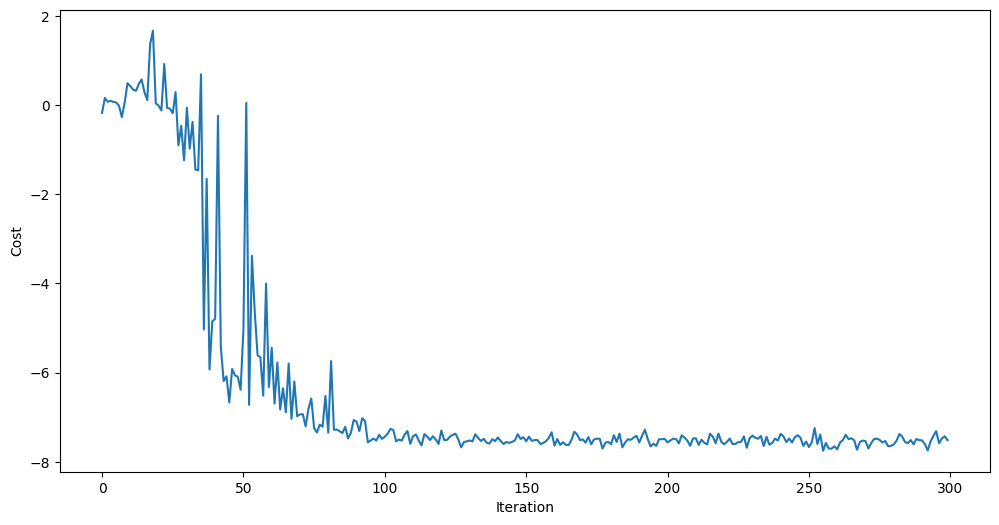

In [267]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

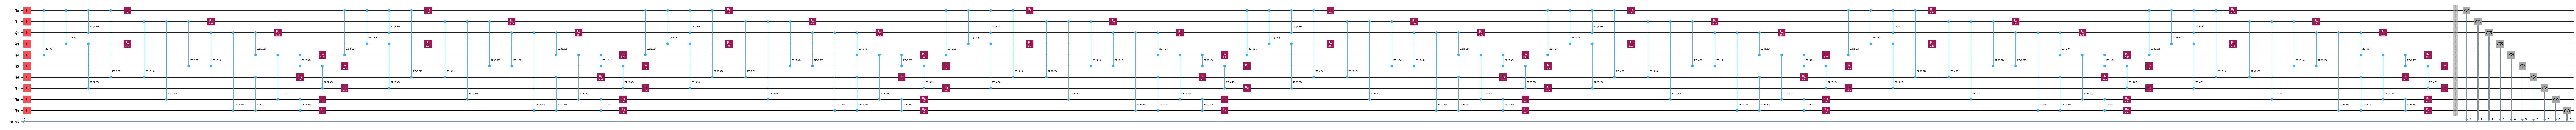

In [268]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [269]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000
# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"
pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
# print(final_distribution_int)

In [270]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]
keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
res = [(values[i], keys[i]) for i in range(len(values))]
res.sort(reverse=True)
res = res[:10]
print(res)
# print("Result bitstring:", most_likely_bitstring)

[(0.0854, 659), (0.0811, 364), (0.0273, 391), (0.0269, 632), (0.0195, 468), (0.0188, 809), (0.0188, 214), (0.0186, 94), (0.0179, 929), (0.0167, 485)]


In [271]:
from typing import Sequence
def evaluate_sample(x: Sequence[int]) -> float:
    assert len(x) == n  # "The length of x must coincide with the number of nodes in the graph."
    return sum((x[u] * (1 - x[v]) + x[v] * (1 - x[u])) * weight for u, v, weight in edge_list)
res.sort(key=lambda x: max([evaluate_sample(to_bitstring(x[1], n)[::-1]) for i in range(20)]), reverse=True)
most_likely_bitstring = to_bitstring(res[0][1], n)[::-1]
print('The value of the cut is:', evaluate_sample(most_likely_bitstring))
print('The solution of the cut is:', most_likely_bitstring)

The value of the cut is: 14
The solution of the cut is: [1, 1, 0, 0, 1, 0, 0, 1, 0, 1]


In [272]:
def max_cut_from_edge_list(edge_list):
    nodes = set()
    for u, v, _ in edge_list:
        nodes.add(u)
        nodes.add(v)
    nodes = list(nodes)
    partition = {node: random.choice([0, 1]) for node in nodes}

    def calculate_cut_value(partition):
        """计算当前划分的割值"""
        cut_value = 0
        for u, v, weight in edge_list:
            if partition[u] != partition[v]: 
                cut_value += weight
        return cut_value
    best_cut_value = calculate_cut_value(partition)
    best_partition = partition.copy()
    for _ in range(100000):
        node = random.choice(nodes)
        partition[node] = 1 - partition[node] 
        current_cut_value = calculate_cut_value(partition)
        if current_cut_value > best_cut_value:
            best_cut_value = current_cut_value
            best_partition = partition.copy()
        else:
            partition[node] = 1 - partition[node]
    return best_cut_value, best_partition
max_cut_value, partition = max_cut_from_edge_list(edge_list)
if partition[0] != most_likely_bitstring[0]:
    for i in range(len(partition)):
        partition[i] = 1 - partition[i]
print("Max-Cut Value:", max_cut_value)
print("Partition:", [partition[i] for i in range(n)])

Max-Cut Value: 12
Partition: [1, 1, 0, 0, 0, 1, 0, 0, 0, 1]


Edge (0, 4): black
Edge (0, 3): red
Edge (0, 2): red
Edge (0, 6): red
Edge (1, 6): red
Edge (1, 8): red
Edge (1, 5): red
Edge (2, 5): black
Edge (2, 9): red
Edge (2, 4): red
Edge (3, 7): red
Edge (4, 8): red
Edge (4, 5): red
Edge (5, 7): red
Edge (6, 9): red
Edge (8, 9): red
Edge (0, 4): red
Edge (0, 3): red
Edge (0, 2): red
Edge (0, 6): red
Edge (1, 6): red
Edge (1, 8): red
Edge (1, 5): black
Edge (2, 5): red
Edge (2, 9): red
Edge (2, 4): black
Edge (3, 7): black
Edge (4, 8): black
Edge (4, 5): red
Edge (5, 7): red
Edge (6, 9): red
Edge (8, 9): red


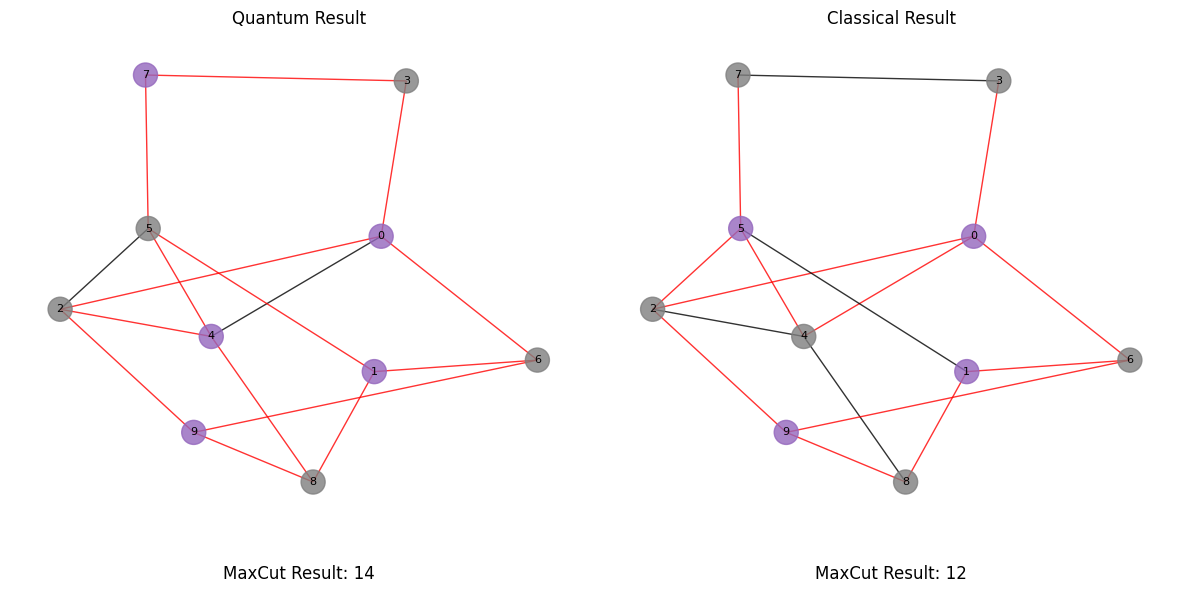

In [273]:
import matplotlib.pyplot as plt
import networkx as nx

# Auxiliary function to plot graphs with custom edge colors
def plot_result(G, x, ax, pos, result, title="Graph Plot"):
    # Node colors based on input x
    node_colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    
    # Edge colors based on node states
    edge_colors = ["red" if x[st] != x[ed] else "black" for (st, ed) in G.edges()]
    
    # Debugging prints
    for edge, color in zip(G.edges(), edge_colors):
        print(f"Edge {edge}: {color}")
    
    # Draw the graph with specified edge and node colors
    nx.draw(
        G,
        pos,
        ax=ax,
        with_labels=False,
        node_color=node_colors,
        edge_color=edge_colors,
        node_size=300,
        alpha=0.8,
    )
    
    # Add node labels
    for node, (x, y) in pos.items():
        ax.text(x, y, str(node), fontsize=8, ha="center", va="center", color="black")
    ax.text(0.5, -0.1, f"MaxCut Result: {result}", fontsize=12, ha="center", va="center", transform=ax.transAxes)
    ax.set_title(title)

# Generate the graph layout only once
pos = nx.spring_layout(graph)  # Generate layout (positions) for nodes

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first result with edge colors
plot_result(
    graph,
    most_likely_bitstring,
    axes[0],
    pos,
    evaluate_sample(most_likely_bitstring),
    title="Quantum Result",
)

# Plot the second result with edge colors
plot_result(
    graph,
    [partition[i] for i in range(len(graph.nodes))],
    axes[1],
    pos,
    max_cut_value,
    title="Classical Result",
)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
